## Analysis Overview
In this project, we aim to answer:
1. Which locations (and even streets, boroughs, and zip codes) in NY have a higher proportion of car accidents? 
2. TODO
3. TODO

In [50]:
# !pip install geopandas
# !pip install geoplot

In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from tool import utils
%matplotlib inline
from datetime import datetime

## Importing Data
The dataset we are working with is from [the City of New York's data catalog on motor vehicle crashes](https://catalog.data.gov/dataset/motor-vehicle-collisions-crashes). The data contains information from all police reported motor vehicle collisions in NYC in 2012-2023. For the purposes of memory, we only use 2022 data. Click [here](https://data.cityofnewyork.us/api/views/h9gi-nx95/rows.csv?accessType=DOWNLOAD) to download the complete dataset. Be aware that this dataset is quite large and is of 403 Mb.

In [53]:
# read csv into dataframe, specifying the year
crashes = utils.read_csv_of_year(2022)
crashes.head(5)

Unnamed: 0  CRASH DATE CRASH TIME   BOROUGH  ZIP CODE   LATITUDE  \
0           1  2022-03-26      11:45       NaN       NaN        NaN   
1           2  2022-06-29       6:55       NaN       NaN        NaN   
2          34  2022-06-29      16:00       NaN       NaN        NaN   
3          37  2022-07-12      17:50  BROOKLYN   11225.0  40.663303   
4          38  2022-03-23      10:00       NaN       NaN        NaN   

   LONGITUDE                LOCATION                    ON STREET NAME  \
0        NaN                     NaN           QUEENSBORO BRIDGE UPPER   
1        NaN                     NaN                THROGS NECK BRIDGE   
2        NaN                     NaN  WILLIAMSBURG BRIDGE OUTER ROADWA   
3  -73.96049  (40.663303, -73.96049)                               NaN   
4        NaN                     NaN                               NaN   

  CROSS STREET NAME             OFF STREET NAME  NUMBER OF PERSONS INJURED  \
0               NaN                         NaN                        1.0   
1               NaN                         NaN                        0.0   
2               NaN                         NaN                        1.0   
3               NaN  44        EMPIRE BOULEVARD                        0.0   
4               NaN        71        EAST DRIVE                        0.0   

   NUMBER OF PERSONS KILLED  NUMBER OF PEDESTRIANS INJURED  \
0                       0.0                              0   
1                       0.0                              0   
2                       0.0                              0   
3                       0.0                              0   
4                       0.0                              0   

   NUMBER OF PEDESTRIANS KILLED  NUMBER OF CYCLIST INJURED  \
0                             0                          0   
1                             0                          0   
2                             0                          0   
3                             0                          0   
4                             0                          0   

   NUMBER OF CYCLIST KILLED  NUMBER OF MOTORIST INJURED  \
0                         0                           1   
1                         0                           0   
2                         0                           1   
3                         0                           0   
4                         0                           0   

   NUMBER OF MOTORIST KILLED  \
0                          0   
1                          0   
2                          0   
3                          0   
4                          0   

                       CONTRIBUTING FACTOR VEHICLE 1  \
0                                  Pavement Slippery   
1                              Following Too Closely   
2                     Driver Inattention/Distraction   
3                                  Oversized Vehicle   
4  Pedestrian/Bicyclist/Other Pedestrian Error/Co...   

  CONTRIBUTING FACTOR VEHICLE 2 CONTRIBUTING FACTOR VEHICLE 3  \
0                           NaN                           NaN   
1                   Unspecified                           NaN   
2                   Unspecified                           NaN   
3                   Unspecified                           NaN   
4                           NaN                           NaN   

  CONTRIBUTING FACTOR VEHICLE 4 CONTRIBUTING FACTOR VEHICLE 5  COLLISION_ID  \
0                           NaN                           NaN       4513547   
1                           NaN                           NaN       4541903   
2                           NaN                           NaN       4542336   
3                           NaN                           NaN       4545699   
4                           NaN                           NaN       4512922   

  VEHICLE TYPE CODE 1                  VEHICLE TYPE CODE 2  \
0               Sedan                                  NaN   
1               Sedan                    

## Mapping

#### Dropping NaNs in Locations column

In [55]:
crashes["LOCATION"].isna().sum()

8938

In [56]:
crashes["LOCATION"].isna().sum()/crashes.shape[0]*100

8.611868538448938

In [57]:
crashes_locations_map = crashes.dropna(subset=["LOCATION"])
# crashes_locations_map.head()

#### Plotting total casualties

In [58]:
crashes_locations_map["TOTAL CASUALTIES"] = crashes_locations_map["NUMBER OF PERSONS INJURED"] + crashes_locations_map["NUMBER OF PERSONS KILLED"]

<ipython-input-58-bfc0c353cf1d>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [59]:
crashes_locations_map_2plus = crashes_locations_map[crashes_locations_map["TOTAL CASUALTIES"] > 2]

In [60]:
fig = px.scatter_mapbox(crashes_locations_map_2plus,
                        lat="LATITUDE",
                        lon="LONGITUDE",
                        color="TOTAL CASUALTIES",
                        size="TOTAL CASUALTIES",
                        zoom=8,
                        height=800,
                        width=1000, color_continuous_scale='thermal')

fig.update_layout(mapbox_style="open-street-map")
fig.show()

#### Clustering Analysis

In [61]:
features = crashes_locations_map[['LATITUDE', 'LONGITUDE']]
features

LATITUDE  LONGITUDE
3       40.663303 -73.960490
5       40.607685 -74.138920
6       40.855972 -73.869896
7       40.790276 -73.939600
8       40.642986 -74.016210
...           ...        ...
103782   0.000000   0.000000
103783  40.877476 -73.836610
103784  40.690180 -73.935600
103785  40.694485 -73.937350
103786  40.687750 -73.790390

[94849 rows x 2 columns]

In [62]:
from sklearn.cluster import KMeans
# create kmeans model/object
kmeans = KMeans(
    init="random",
    n_clusters=8,
    n_init=10,
    max_iter=300,
    random_state=42
)

In [63]:
# do clustering
kmeans.fit(features)
# save results
labels = kmeans.labels_

In [64]:
# send back into dataframe and display it
crashes_locations_map['cluster'] = labels
# display the number of mamber each clustering
_clusters = crashes_locations_map.groupby('cluster').count()['COLLISION_ID']
# print(_clusters)

cluster
0    16629
1    13625
2    12841
3     4624
4    11745
5    18278
6     1864
7    15243
Name: COLLISION_ID, dtype: int64


<ipython-input-64-6235f9a12ff7>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [65]:
fig = px.scatter_mapbox(crashes_locations_map,
                        lat="LATITUDE",
                        lon="LONGITUDE",
                        color="cluster",
                        size="TOTAL CASUALTIES",
                        zoom=8,
                        height=800,
                        width=1000, color_continuous_scale='thermal')

fig.update_layout(mapbox_style="open-street-map")
fig.show()

## EDA

### Collisions by Geography

In [66]:
# function to add value labels
# credit: GeeksforGeeks
def addlabels(x, y):
    for i in range(len(x)):
        plt.text(i, y[i]*1.01, y[i], ha="center")

#### Boroughs

In [67]:
boroughs_data = crashes.groupby("BOROUGH").count()["COLLISION_ID"]

# population source: http://www.citypopulation.de/en/usa/newyorkcity/
population = pd.Series(data={'BRONX': 1379946, 'BROOKLYN': 2590516, 'MANHATTAN': 1596273, 'QUEENS': 2278029, 'STATEN ISLAND': 491133})

per capita

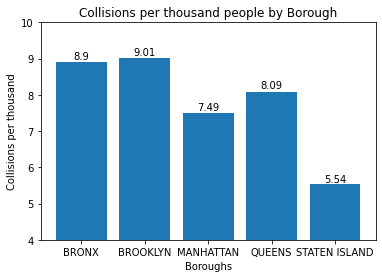

In [68]:
x = boroughs_data.index
y = round(boroughs_data.values / population * 1000, 2)

plt.bar(x, y)
addlabels(x, y)
plt.xlabel("Boroughs")
plt.ylabel("Collisions per thousand")
plt.title("Collisions per thousand people by Borough")
plt.ylim((4, 10))
plt.show()

#### Zip Code
TODO: Discuss - How to display this data more visually appealingly?

In [69]:
zc_data = crashes.groupby("ZIP CODE").count()["CRASH DATE"]

In [70]:
zc_df = pd.DataFrame(zc_data).reset_index()
zc_df.rename(columns={"CRASH DATE": "COUNT"}, inplace=True)
zc_df["ZIP CODE"] = zc_df["ZIP CODE"].astype(int)
zc_df.sort_values(by="COUNT", ascending=False)

ZIP CODE  COUNT
123     11207   1763
128     11212   1128
151     11236   1111
124     11208   1099
119     11203    996
..        ...    ...
55      10153      1
56      10154      1
58      10158      1
59      10165      1
57      10155      1

[210 rows x 2 columns]

<img src="data/zip code distributed crash events.png" alt="Alternative text" width="200"/>

### Collisions by Demography

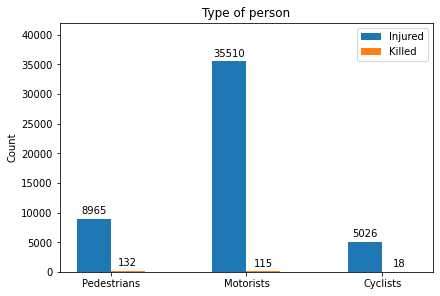

In [71]:
# credit: https://matplotlib.org/stable/gallery/lines_bars_and_markers/barchart.html

types = ("Pedestrians", "Motorists", "Cyclists")
counts = {"Injured": (crashes["NUMBER OF PEDESTRIANS INJURED"].sum(), crashes["NUMBER OF MOTORIST INJURED"].sum(), crashes["NUMBER OF CYCLIST INJURED"].sum()),
          "Killed": (crashes["NUMBER OF PEDESTRIANS KILLED"].sum(), crashes["NUMBER OF MOTORIST KILLED"].sum(), crashes["NUMBER OF CYCLIST KILLED"].sum()),
          }

x = np.arange(len(types))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for i, j in counts.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, j, width, label=i)
    ax.bar_label(rects, padding=3)
    multiplier += 1

ax.set_ylabel('Count')
ax.set_title('Type of person')
ax.set_xticks(x + width*0.5, types)
ax.legend()
ax.set_ylim(0, 42000)
plt.show()

### Collisions by Causes
TODO: 
- Discuss - What is the difference amongst cols 1-5 of Contributing Factor Vehicle and Vehicle Type Code?
- Should we stratify by borough?

#### Top 10 Contributing Factor Vehicle 1

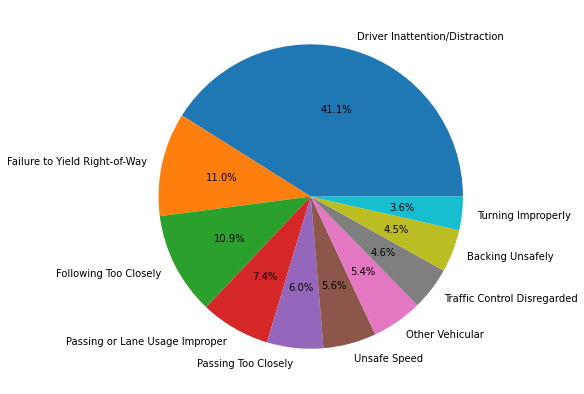

In [72]:
cfv = utils.get_contributing_factor(crashes).sort_values("CRASH DATE", ascending=False).iloc[1:11]
labels = cfv.index
sizes = cfv["CRASH DATE"]
fig, ax = plt.subplots(figsize=(10, 7))
ax.pie(sizes, labels=labels, autopct='%1.1f%%')
# plt.legend(labels, bbox_to_anchor=(1.5, 0.25, 0.5, 0.5))
plt.show()

In [73]:
# For the remaining Contributing Vehicle Factor columns
# the top most reason is "Unspecified" so not very helpful visualizations

#### Top 10 Vehicle Type Code 1
TODO: Maybe calculate the most common vehicle type codes across all 5 columns?

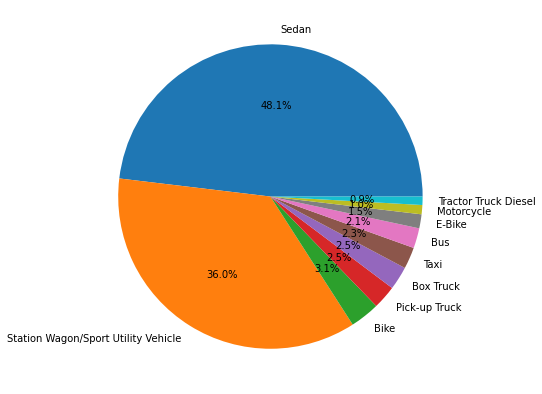

In [74]:
# vtc1 = crashes.groupby("VEHICLE TYPE CODE 1").count()["CRASH DATE"].sort_values(ascending=False).head(10)
vtc = utils.get_vehicle_type(crashes).sort_values("CRASH DATE", ascending=False).iloc[:10]
labels = vtc.index
sizes = vtc["CRASH DATE"]

fig, ax = plt.subplots(figsize=(10, 7))
ax.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.show()

### Collisions by Time

In [76]:
# add month, day and hour to the dataframe
utils.time_processing(crashes)

In [107]:
crashes['CRASH HOUR'][0]

11

In [77]:
crashes

Unnamed: 0 CRASH DATE CRASH TIME   BOROUGH  ZIP CODE   LATITUDE  \
0                1 2022-03-26      11:45       NaN       NaN        NaN   
1                2 2022-06-29       6:55       NaN       NaN        NaN   
2               34 2022-06-29      16:00       NaN       NaN        NaN   
3               37 2022-07-12      17:50  BROOKLYN   11225.0  40.663303   
4               38 2022-03-23      10:00       NaN       NaN        NaN   
...            ...        ...        ...       ...       ...        ...   
103782     1984602 2022-04-24      13:00  BROOKLYN   11233.0   0.000000   
103783     1984724 2022-12-06      15:52     BRONX   10475.0  40.877476   
103784     1984763 2022-05-26       0:00  BROOKLYN   11221.0  40.690180   
103785     1984817 2022-07-18      19:00  BROOKLYN   11206.0  40.694485   
103786     1985218 2022-12-11      12:00    QUEENS   11434.0  40.687750   

        LONGITUDE                LOCATION                    ON STREET NAME  \
0             NaN                     NaN           QUEENSBORO BRIDGE UPPER   
1             NaN                     NaN                THROGS NECK BRIDGE   
2             NaN                     NaN  WILLIAMSBURG BRIDGE OUTER ROADWA   
3       -73.96049  (40.663303, -73.96049)                               NaN   
4             NaN                     NaN                               NaN   
...           ...                     ...                               ...   
103782    0.00000              (0.0, 0.0)                               NaN   
103783  -73.83661  (40.877476, -73.83661)                 BAYCHESTER AVENUE   
103784  -73.93560    (40.69018, -73.9356)                               NaN   
103785  -73.93735  (40.694485, -73.93735)                      LEWIS AVENUE   
103786  -73.79039   (40.68775, -73.79039)                  LINDEN BOULEVARD   

       CROSS STREET NAME             OFF STREET NAME  \
0                    NaN                         NaN   
1                    NaN                         NaN   
2                    NaN                         NaN   
3                    NaN  44        EMPIRE BOULEVARD   
4                    NaN        71        EAST DRIVE   
...                  ...                         ...   
103782               NaN    506       DECATUR STREET   
103783      GIVAN AVENUE                         NaN   
103784               NaN     810       GREENE AVENUE   
103785       HART STREET                         NaN   
103786        157 STREET                         NaN   

        NUMBER OF PERSONS INJURED  NUMBER OF PERSONS KILLED  \
0                             1.0                       0.0   
1                             0.0                       0.0   
2                             1.0                       0.0   
3                             0.0                       0.0   
4                             0.0                       0.0   
...                           ...                       ...   
103782                        0.0                       0.0   
103783                        0.0                       0.0   
103784                        0.0                       0.0   
103785                        1.0                       0.0   
103786                        0.0                       0.0   

        NUMBER OF PEDESTRIANS INJURED  NUMBER OF PEDESTRIANS KILLED  \
0                                   0                             0   
1                                   0                             0   
2                                   0                             0   
3                                   0                             0   
4                                   0                             0   
...                               ...                           ...   
103782                              0                             0   
103783                              0                             0   
103784                              0                             0   
103785            

#### Month

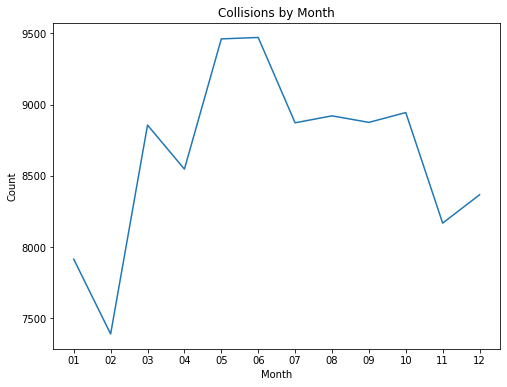

In [78]:
month_data = crashes.groupby("CRASH MONTH").count()["CRASH TIME"]
plt.figure(figsize=(8, 6))
# sns.lineplot(month_data.index, month_data.values)
plt.plot(month_data.index, month_data.values)
plt.title("Collisions by Month")
plt.xlabel("Month")
plt.ylabel("Count")
plt.show()

#### Day

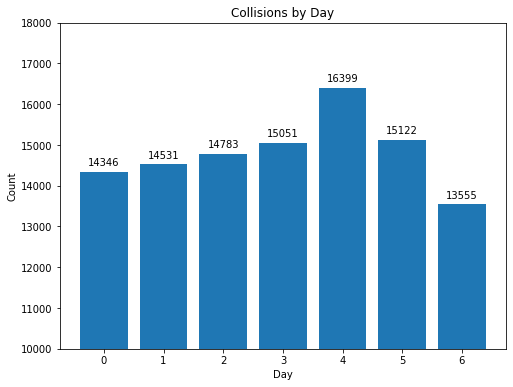

In [79]:
day_data = crashes.groupby("DAYOFWEEK").count()["CRASH TIME"]
plt.figure(figsize=(8, 6))
plt.bar(day_data.index, day_data.values)
addlabels(day_data.index, day_data.values)
plt.title("Collisions by Day")
plt.xlabel("Day")
plt.ylabel("Count")
plt.ylim((10000, 18000))
plt.show()

#### Hour

In [148]:
weekday_hour_data = crashes[crashes['DAYOFWEEK'] < 5].groupby("CRASH HOUR").count()["CRASH TIME"]/5
weekend_hour_data = crashes[crashes['DAYOFWEEK'] > 4].groupby("CRASH HOUR").count()["CRASH TIME"]/2

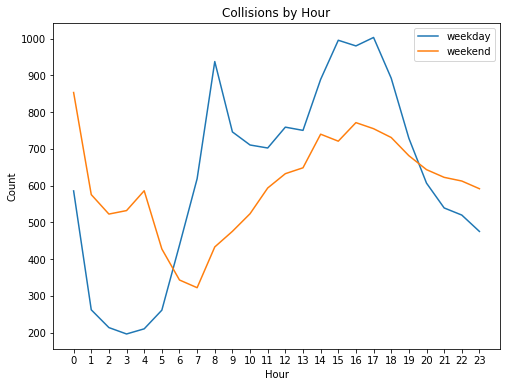

In [150]:
plt.figure(figsize=(8, 6))
plt.plot(weekday_hour_data.index, weekday_hour_data.values, label='weekday')
plt.plot(weekend_hour_data.index, weekend_hour_data.values, label='weekend')
plt.title("Collisions by Hour")
plt.xlabel("Hour")
plt.ylabel("Count")
plt.xticks(np.linspace(0, 23, 24))
plt.legend()
plt.show()

### Bivariate analysis: 
Investigate relationships between pairs of features, using scatter plots, box plots, or violin plots. For example, you can explore the relationship between contributing factors and the number of persons injured, or between crash time and crash severity.

In [82]:
crashes_18_22 = dict.fromkeys(range(2014, 2023))
for year in crashes_18_22.keys():
    crashes_18_22[year] = utils.read_csv_of_year(year)
    utils.time_processing(crashes_18_22[year])
    α = 1
    crashes_18_22[year]["TOTAL CASUALTIES"] = crashes_18_22[year]["NUMBER OF PERSONS INJURED"] + α * crashes_18_22[year]["NUMBER OF PERSONS KILLED"]

casualties_18_22 = dict.fromkeys(range(2014, 2023))
for year in casualties_18_22.keys():
    casualties_18_22[year] = crashes_18_22[year].groupby("CRASH HOUR")["TOTAL CASUALTIES"].mean()

/home/jovyan/hw06/project-group19/tool/utils.py:86: DtypeWarning:

Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.

/home/jovyan/hw06/project-group19/tool/utils.py:86: DtypeWarning:

Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.



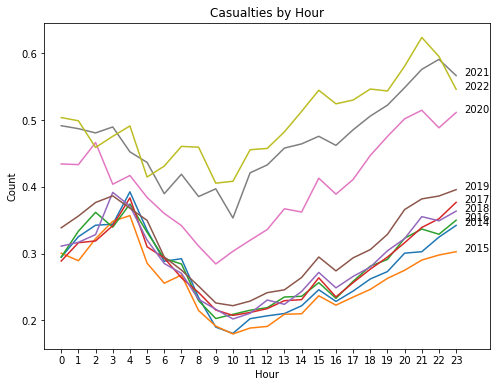

In [83]:
plt.figure(figsize=(8, 6))
for year in casualties_18_22.keys():
    plt.plot(casualties_18_22[year].index, casualties_18_22[year].values, label=year)
    plt.text(23.5, casualties_18_22[year].values[23], year)
plt.title("Casualties by Hour")
plt.xlabel("Hour")
plt.ylabel("Count")
plt.xticks(np.linspace(0, 23, 24))
plt.xlim((-1, 25))
plt.show()

In [151]:
numkilled_18_22 = dict.fromkeys(range(2014, 2023))

for year in crashes_18_22.keys():
    numkilled_18_22[year] = crashes_18_22[year]["NUMBER OF PERSONS KILLED"].sum()

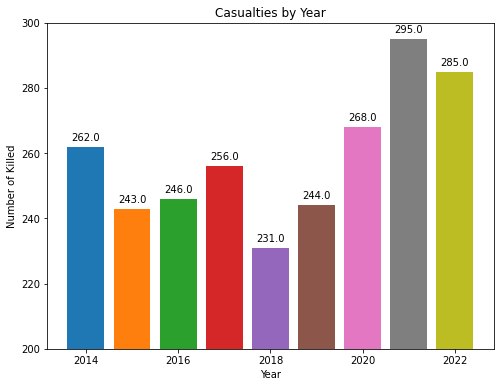

In [86]:
plt.figure(figsize=(8, 6))
for year in casualties_18_22.keys():
    plt.bar(year, numkilled_18_22[year], label=year)
    plt.text(year, numkilled_18_22[year]+2, numkilled_18_22[year], ha="center")
plt.title("Casualties by Year")
plt.xlabel("Year")
plt.ylabel("Number of Killed")
plt.ylim((200, 300))
plt.show()

#### Predicting car crash severity
Let’s develop a classification machine learning model using a random forest. Define car accident severity as three levels according to the casualties: 

minor injury level: 2 or less people injured, no death reported. Label: 0

major injury level: 3 or more people injured, no death reported. Label: 1

fatal injury level: at least one person killed. Label: 2

In [87]:
injury_conditions = [
    (crashes["NUMBER OF PERSONS KILLED"] >= 1),
    (crashes["NUMBER OF PERSONS INJURED"] >= 3) & (crashes["NUMBER OF PERSONS KILLED"] == 0),
    (crashes["NUMBER OF PERSONS INJURED"] <= 2) & (crashes["NUMBER OF PERSONS KILLED"] == 0),
]

injury_values = [2, 1, 0]

In [88]:
time_conditions = [
    (crashes['CRASH HOUR'] <= 11) & (crashes['CRASH HOUR'] >= 6),
    (crashes['CRASH HOUR'] <= 17) & (crashes['CRASH HOUR'] >= 12),
    (crashes['CRASH HOUR'] <= 5) | (crashes['CRASH HOUR'] >= 18),
]

time_values = ['morning', 'afternoon', 'after sunset']

In [89]:
vehicle1_conditions = [
    (crashes['VEHICLE TYPE CODE 1'].str.contains('Sedan', na=False)),
    (crashes['VEHICLE TYPE CODE 1'].str.contains('Sport', na=False)),
    (crashes['VEHICLE TYPE CODE 1'].str.contains('Truck', na=False)),
    (crashes['VEHICLE TYPE CODE 1'].str.contains('Taxi', na=False)),
    (crashes['VEHICLE TYPE CODE 1'].str.contains('Bus', na=False)),
    (crashes['VEHICLE TYPE CODE 1'].str.contains('Motor', na=False)),
    (crashes['VEHICLE TYPE CODE 1'].str.contains('Bike', na=False)),
    (crashes['VEHICLE TYPE CODE 1'].str.contains('Pick-up', na=False)),
    (crashes['VEHICLE TYPE CODE 1'].notna() | crashes['VEHICLE TYPE CODE 1'].isna())
]
vehicle1_values = ['sedan', 'suv', 'truck', 'taxi', 'bus', 'motor', 'bike', 'pick-up', 'other']

vehicle2_conditions = [
    (crashes['VEHICLE TYPE CODE 2'].str.contains('Sedan', na=False)),
    (crashes['VEHICLE TYPE CODE 2'].str.contains('Sport', na=False)),
    (crashes['VEHICLE TYPE CODE 2'].str.contains('Truck', na=False)),
    (crashes['VEHICLE TYPE CODE 2'].str.contains('Taxi', na=False)),
    (crashes['VEHICLE TYPE CODE 2'].str.contains('Bus', na=False)),
    (crashes['VEHICLE TYPE CODE 2'].str.contains('Motor', na=False)),
    (crashes['VEHICLE TYPE CODE 2'].str.contains('Bike', na=False)),
    (crashes['VEHICLE TYPE CODE 2'].str.contains('Pick-up', na=False)),
    (crashes['VEHICLE TYPE CODE 2'].notna() | crashes['VEHICLE TYPE CODE 2'].isna())
]
vehicle2_values = ['sedan', 'suv', 'truck', 'taxi', 'bus', 'motor', 'bike', 'pick-up', 'other']

In [90]:
# add labels of injury severity
crashes['INJURY LEVEL'] = np.select(injury_conditions, injury_values)
crashes['TIME OF DAY'] = np.select(time_conditions, time_values)
crashes['VEHICLE TYPE 1'] = np.select(vehicle1_conditions, vehicle1_values)
crashes['VEHICLE TYPE 2'] = np.select(vehicle2_conditions, vehicle2_values)

In [92]:
col_list = ['CONTRIBUTING FACTOR VEHICLE 1',
       'CONTRIBUTING FACTOR VEHICLE 2', 'CONTRIBUTING FACTOR VEHICLE 3',
       'CONTRIBUTING FACTOR VEHICLE 4', 'CONTRIBUTING FACTOR VEHICLE 5']
crashes['NUM OF CARS'] = 5 - crashes[col_list].isna().sum(axis=1)

In [130]:
data = crashes[crashes['VEHICLE TYPE 1'] != 'other']
df0 = data[data['INJURY LEVEL'] == 0].sample(20000)
df1 = data[data['INJURY LEVEL'] == 1]
df2 = data[data['INJURY LEVEL'] == 2]
frames = [df0, df1, df2]
data = pd.concat(frames)
data = data.dropna(subset=['BOROUGH'])

In [131]:
features = ['TIME OF DAY', 'NUM OF CARS', 'DAYOFWEEK', 'VEHICLE TYPE 1', 'VEHICLE TYPE 2', 'BOROUGH']  #
X = data[features]
y = data['INJURY LEVEL']

In [132]:
# one hot encoding
encoded_X = pd.get_dummies(X, drop_first=True)
encoded_X

NUM OF CARS  DAYOFWEEK  TIME OF DAY_afternoon  TIME OF DAY_morning  \
99908             1          6                      1                    0   
28191             1          0                      0                    0   
67448             1          2                      0                    1   
34085             3          5                      0                    1   
35124             2          0                      0                    1   
...             ...        ...                    ...                  ...   
103667            1          4                      1                    0   
103734            1          4                      0                    0   
103735            2          2                      1                    0   
103736            2          2                      1                    0   
103738            1          6                      0                    0   

        VEHICLE TYPE 1_bus  VEHICLE TYPE 1_motor  VEHICLE TYPE 1_sedan  \
99908                    0                     0                     1   
28191                    0                     0                     0   
67448                    1                     0                     0   
34085                    0                     0                     0   
35124                    0                     0                     0   
...                    ...                   ...                   ...   
103667                   0                     0                     0   
103734                   0                     0                     0   
103735                   0                     0                     0   
103736                   0                     0                     0   
103738                   0                     0                     0   

        VEHICLE TYPE 1_suv  VEHICLE TYPE 1_taxi  VEHICLE TYPE 1_truck  \
99908                    0                    0                     0   
28191                    1                    0                     0   
67448                    0                    0                     0   
34085                    1                    0                     0   
35124                    1                    0                     0   
...                    ...                  ...                   ...   
103667                   1                    0                     0   
103734                   1                    0                     0   
103735                   1                    0                     0   
103736                   1                    0                     0   
103738                   1                    0                     0   

        VEHICLE TYPE 2_bus  VEHICLE TYPE 2_motor  VEHICLE TYPE 2_other  \
99908                    0                     0                     1   
28191                    0                     0                     1   
67448                    0                     0                     1   
34085                    0                     0                     0   
35124                    0                     0                     1   
...                    ...                   ...                   ...   
103667                   0                     0                     1   
103734                   0                     0                     1   
103735                   0                     1                     0   
103736                   0                     0                     0   
103738                   0                     0                     1   

        VEHICLE TYPE 2_sedan  VEHICLE TYPE 2_suv  VEHICLE TYPE 2_taxi  \
99908                      0                   0                    0   
28191                      0                   0                    0   
67448                      0                   0                    0   
34085                      1                   0                    0   
35124                      0                   0   

#### run on Random Forest model

In [140]:
# import the necessary liabrary
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, f1_score

# train and test split and building baseline model to predict target features
X_train, X_test, y_train, y_test = train_test_split(encoded_X, y, test_size=0.2, random_state=42)

# modelling using random forest baseline
rf = RandomForestClassifier(n_estimators=500, max_depth=30, random_state=42)
rf.fit(X_train, y_train)

# predicting on test data
predics = rf.predict(X_test)

In [134]:
# train score
print('Training accuracy: %.2f %%' % (rf.score(X_train, y_train)*100))
# test score
print('Training accuracy: %.2f %%' % (rf.score(X_test, y_test)*100))

Training accuracy: 91.71 %
Training accuracy: 88.71 %


#### run on logistic regression model

In [135]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve, roc_auc_score, classification_report, accuracy_score, confusion_matrix 

In [136]:
scaler = StandardScaler()
lr = LogisticRegression()
model1 = Pipeline([('standardize', scaler), ('log_reg', lr)])

In [137]:
model1.fit(X_train, y_train)

Pipeline(steps=[('standardize', StandardScaler()),
                ('log_reg', LogisticRegression())])

In [138]:
Pipeline(steps=[('standardize', StandardScaler()),
                ('log_reg', LogisticRegression())])

Pipeline(steps=[('standardize', StandardScaler()),
                ('log_reg', LogisticRegression())])

In [142]:
y_train_hat = model1.predict(X_train)
y_train_hat_probs = model1.predict_proba(X_train)[:, 1]
train_accuracy = accuracy_score(y_train, y_train_hat)*100
# print('Confusion matrix:\n', confusion_matrix(y_train, y_train_hat))
print('Training accuracy: %.2f %%' % train_accuracy)

Training accuracy: 89.62 %


In [143]:
y_test_hat = model1.predict(X_test)
y_test_hat_probs = model1.predict_proba(X_test)[:, 1]
test_accuracy = accuracy_score(y_test, y_test_hat)*100
print('Testing accuracy: %.2f %%' % test_accuracy)

Testing accuracy: 90.13 %


A test score of around 90% means that your random forest model is correctly predicting the injury severity of car accidents about 90% of the time. While this is much better than random guessing, there is still room for improvement. Here are a few suggestions on how to improve it:

Feature engineering: The features selected might not be sufficient. Could consider adding more features, such as weather conditions, road conditions, speed limits, or driver demographics. 

Hyperparameter tuning: Random forest models have several hyperparameters that can significantly impact their performance. Use techniques like grid search or random search to find the optimal hyperparameters for your model (e.g., the number of trees, maximum depth, minimum samples per leaf).

Feature selection: Some features might not contribute to improving the model's performance, or they could be causing multicollinearity. Apply feature selection techniques like recursive feature elimination, LASSO regression, or chi-squared test to find the most relevant features for your model.

Ensemble methods: Combine multiple models using techniques like bagging, boosting, or stacking to improve the overall performance.